In [0]:
import operator
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Scenario
Many in industry have taken the leap from on premise to cloud based infrastructure. In the following scenario, we will examine this real world problem using Monte Carlo simulation for standard line items of an on premise to cloud migration. For you inidividual case, you may have other cost to consider as well. For the cloud provider, we are using Google and Databricks for analytics platform. Here I have rolled up their cost into one line item but you may want to break them out for a more robust analysis.

In the case laid out below, we have that
1. `data_center_thb` is the cost data center per year in Thai Baht.
2. `servers` are the number of servers we maintain.
3. `software` is the cost of enterprise licenses we pay for.
4. `engineers_thb` is the cost of all our engineers who would have responsibilities covered by migrating cloud.
5. `pro_service` is the professional service fee from GCP and Databricks for transitioning from on premise to cloud.
6. `hurdle_rate` is the business risk of capital rate; however, we can use a distribution for this value to look different rates.

This notebook can be modified for traditional applications such as manufactoring or other tech style evaluations. This isn't solely for analyzing on premise to cloud but just the example used here today.

In [0]:
data_center_thb = 35000000
servers = 250
software = 500000
engineers_thb = 2220000 * 20   # 20 engineers at 2.2M THB a year
pro_service = -1000000
tax_rate = .2                  # corporate tax rate incurred on all positive revenues
hurdle_rate = .1               # risk adjusted hurdle rate can compute by using the function below instead of this static value

## Standard Distributions
Common distributions to use during capital budgeting Monte Carlo are `triangular`, `uniform`, and `normal`. However, others may be used with care. If one uses a normal distribution, remember the tails trail off to negative and positive infinity which may or may not make sense for your scenario. Even though the probability may be small of selection beyond 3 standard deviations, it can happen in large number of simulations. With normal distributions, it might be good to define lower and upper bounds to assign to anything selected beyond a certain range. Another option is to use distributions that have support and only needing to bound at one extreme.

In the distributions below, I demonstrate the use of `uniform`, `triangular`, and `normal`, but dont feel limited to these. If you know one of your cost has a `beta` distribution, use it. If you are a US user with US cost, you will not need the exchange rate throughout the this demo. You can either remove it or set it to 1 since dividing by will not change the end result.

In [0]:
def hardware_thb():
    """
    Cost of the hardware per server.
    """
    return np.random.uniform(850000, 1000000)


def software_increase():
    """
    Percentage increase of software licenses yearly.
    """
    return np.random.triangular(1.005, 1.025, 1.05)


def engineers_increase():
    """
    Percentage increase of the salary of the engineers per year.
    """
    return np.random.triangular(1.05, 1.085, 1.12)


def engineers_resource_utilization():
    """
    The percentage of billable time the engineers would spend on cloud related task that would be
    freed up if we move to cloud.
    """
    return np.random.triangular(0.25, 1/3, 0.5)


def data_center_cost_increase():
    """
    Data center shared space cost increase yearly.
    """
    return np.random.triangular(1.01, 1.02, 1.05)


def exchange_thb():
    """
    THB to USD exchange rate flucuation with a mean of 32 and SD of 2. In this case, we will bound the return
    values to a minimum of 28 and a maximum of 38.
    """
    thb = np.random.normal(32, 2)
    if thb < 30:
      return 30
    if thb > 35:
      return 35
    return thb


def year_one_dual_cost():
    """
    During the first year transition phase, we will experience partial on premise and cloud cost depending
    on the speed of migration.
    """
    return np.random.triangular(.25, .35, .5)
  
  
def risk_adjusted_hurdle():
  """
  We cannot account for every risk profile in this simulation; therefore, we can capture some of this additional
  risk by considering hurdle rate which incorporates a higher return needed.
  """
  return np.random.triangular(.10, .125, .25)

In [0]:
def create_data():
    # if you have more line items to account for, update the indices needed here.
    # setup dataframe
    df = pd.DataFrame([], columns=[f"year_{i}" for i in range(0, 11)])
    df.loc[:, "index"] = ["data_center", "hardware", "engineers", "software", "cloud_cost", "cashflows", "after_tax"]
    df.set_index("index", inplace=True)
    df.fillna(0, inplace=True)
    # initialize year_0
    df.loc["cloud_cost", "year_0"] = pro_service
    df.loc["cashflows", "year_0"] = pro_service
    df.loc["after_tax", "year_0"] = pro_service
    
    db_gcp_cost = 3100000  # adjust for your real numbers this is also a combine GCP and DB cost. Feel free to separate your costs out for better simulation results

    for i in range(1, 11):
        # not the cleanest but just doing first year value setting and checking for cycle update params
        if i == 1:
            # these should be known for year 1 and static: exchange rate, hardware and simulate beyond year one
            exchange = exchange_thb()
            dual_cost = year_one_dual_cost()                              
            hardware = hardware_thb() / exchange / 5 * servers       # normal year one would be known not sampled
            engineer_pay = engineers_thb
        elif i == 2:
            # cloud cost after migration split would be the original cost multiplied by increase related to data
            # these cloud cost can be broken out to better simulate this increase
            db_gcp_cost = db_gcp_cost * software_increase()
        elif i == 6:
            hardware = hardware_thb() / exchange_thb() / 5 * servers  # hardware upgrade cycle split cost over 5 years
            db_gcp_cost = df.loc["cloud_cost", f"year_{i - 1}"] * software_increase()
        else:
            db_gcp_cost = df.loc["cloud_cost", f"year_{i - 1}"] * software_increase()
            
        if i > 1:
          engineer_pay *= engineers_increase()
  
        # populate the data
        df.loc["data_center", f"year_{i}"] = df.loc["data_center", f"year_{i - 1}"] * data_center_cost_increase() if i != 1 else data_center_thb / exchange
        df.loc["hardware", f"year_{i}"] = hardware
        df.loc["engineers", f"year_{i}"] = engineers_thb / exchange * engineers_resource_utilization() if i == 1 else engineer_pay / exchange_thb() * engineers_resource_utilization()
        df.loc["software", f"year_{i}"] = software if i == 1 else df.loc["software", f"year_{i - 1}"] * software_increase()
        df.loc["cloud_cost", f"year_{i}"] = db_gcp_cost * (1 - dual_cost) + df.loc[["data_center", "hardware", "engineers", "software"], "year_1"].sum() * dual_cost if i == 1 else db_gcp_cost
        df.loc["cashflows", f"year_{i}"] = df.loc[["data_center", "hardware", "engineers", "software"], f"year_{i}"].sum() - df.loc["cloud_cost", f"year_{i}"]
        df.loc["after_tax", f"year_{i}"] = df.loc["cashflows", f"year_{i}"] if df.loc["cashflows", f"year_{i}"] <= 0 else df.loc["cashflows", f"year_{i}"] * 0.8
        
    return df


In [0]:
# take a look at the dataframe and see how each call changes the results
create_data()

Out[42]:

,year_0,year_1,year_2,year_3,year_4,year_5,year_6,year_7,year_8,year_9,year_10
index,,,,,,,,,,,
data_center,0,1094640.68,1134795.70,1149282.00,1175897.18,1198657.87,1231134.01,1253641.44,1286114.63,1324677.18,1382496.53
hardware,0,1458137.32,1458137.32,1458137.32,1458137.32,1458137.32,1654486.61,1654486.61,1654486.61,1654486.61,1654486.61
engineers,0,527082.95,417261.53,469641.58,641337.82,852530.01,658157.12,885766.99,1147979.41,949464.90,979854.71
software,0,500000.00,513720.98,522238.88,542780.99,552255.93,563581.65,583039.33,594768.56,608009.32,625427.95
cloud_cost,-1000000,3280825.57,3146329.42,3211088.81,3323648.52,3398133.02,3538576.94,3627182.87,3695967.92,3853406.73,4005990.15
cashflows,-1000000,299035.37,377586.12,388210.97,494504.80,663448.11,568782.45,749751.51,987381.29,683231.29,636275.66
after_tax,-1000000,239228.30,302068.90,310568.78,395603.84,530758.49,455025.96,599801.21,789905.03,546585.03,509020.53


# 25000 Simulation
This is a bit slow at 25k but not bad at 10k. we can always use the multiple processing package to speed up the run time.

In [0]:
# collect data for before and after tax npv and irr for years 3, 5, 10
npv_irr_10 = []
npv_irr_after_tax_10 = []
npv_irr_5 = []
npv_irr_after_tax_5 = []
npv_irr_3 = []
npv_irr_after_tax_3 = []
for _iter in range(1, 25001):
    df = create_data()
    # for a static hurdle rate, risk = hurdle_rate
    risk = risk_adjusted_hurdle()
    npv_irr_10.append(
        (
            round(npf.npv(risk, df.loc["cashflows", :].values[1:11]) + df.loc["cashflows", "year_0"], 2),
            round(npf.irr(df.loc["cashflows", :].values[0:11]), 2) * 100
        )
    )
    npv_irr_after_tax_10.append(
        (
            round(npf.npv(risk, df.loc["after_tax", :].values[1:11]) + df.loc["after_tax", "year_0"], 2),
            round(npf.irr(df.loc["after_tax", :].values[0:11]), 2) * 100
        )
    )
    npv_irr_5.append(
        (
            round(npf.npv(risk, df.loc["cashflows", :].values[1:6]) + df.loc["cashflows", "year_0"], 2),
            round(npf.irr(df.loc["cashflows", :].values[0:6]), 2) * 100
        )
    )
    npv_irr_after_tax_5.append(
        (
            round(npf.npv(risk, df.loc["after_tax", :].values[1:6]) + df.loc["after_tax", "year_0"], 2),
            round(npf.irr(df.loc["after_tax", :].values[0:6]), 2) * 100
        )
    )
    npv_irr_3.append(
        (
            round(npf.npv(risk, df.loc["cashflows", :].values[1:4]) + df.loc["cashflows", "year_0"], 2),
            round(npf.irr(df.loc["cashflows", :].values[0:4]), 2) * 100
        )
    )
    npv_irr_after_tax_3.append(
        (
            round(npf.npv(risk, df.loc["after_tax", :].values[1:4]) + df.loc["after_tax", "year_0"], 2),
            round(npf.irr(df.loc["after_tax", :].values[0:4]), 2) * 100
        )
    )

In [0]:
def get_results_plot(npv_irr_array, num_years, before_tax=True):
    """
    Plot the distributions of NPV for the given years and factor in tax or not.
    :param npv_irr_array: array containing a tuple of npv, irr
    :param num_years: in our case, I only look at 3, 5, 10
    :para before_tax: if you want after tax calculations, you would specify that here.
    """
    npv = list(map(operator.itemgetter(0), npv_irr_array))
    irr = list(map(operator.itemgetter(1), npv_irr_array))

    if before_tax:
      naming = "before"
    else:
      naming = "after"

    plt.figure(figsize=(15, 10))
    plt.xlabel("NPV in USD")
    plt.ylabel("Frequency")
    plt.title(f"{num_years} Year {naming} Tax NPV")
    N, bins, patches = plt.hist(npv, bins=85, density=True, stacked=True)
    
    # pick 2 colors for NPV < 0 and > 0; red and green/black looked bad in my opinion
    for i in range(0, len(bins) - 1):
      if patches[i].xy[0] < 0:
        patches[i].set_facecolor("black")
      else:
        patches[i].set_facecolor("blue")
    
    plt.show()
    return npv, irr

# Before Tax NPV

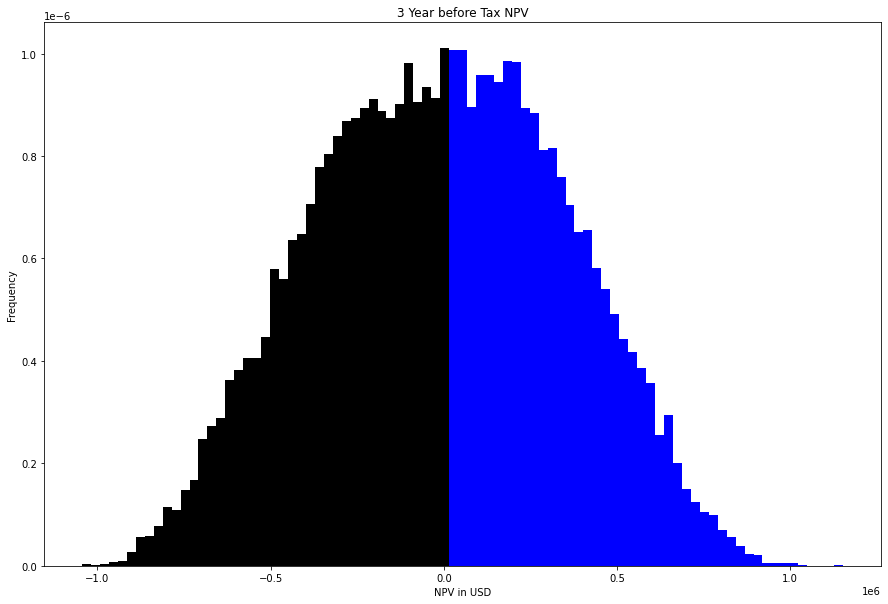

In [0]:
npv_3, irr_3 = get_results_plot(npv_irr_3, "3")

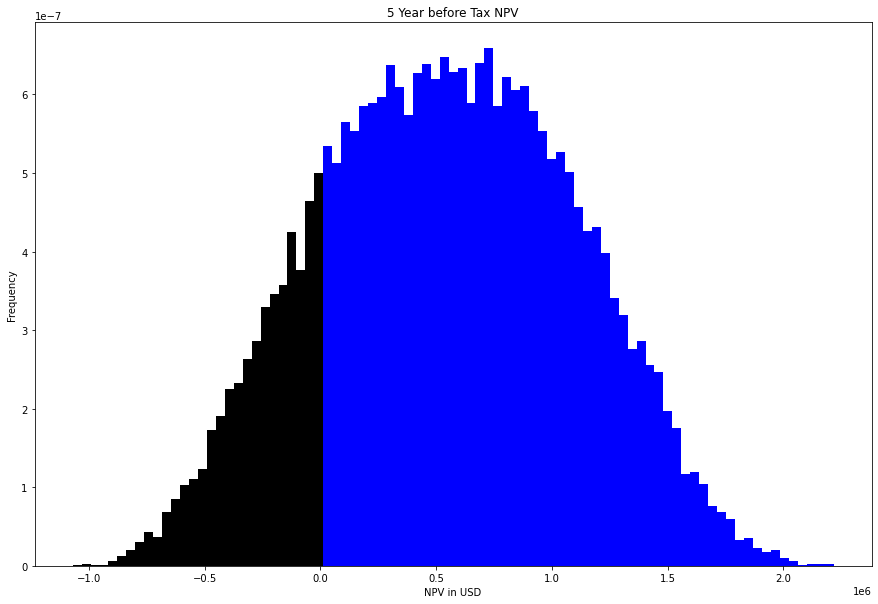

In [0]:
npv_5, irr_5 = get_results_plot(npv_irr_5, "5")

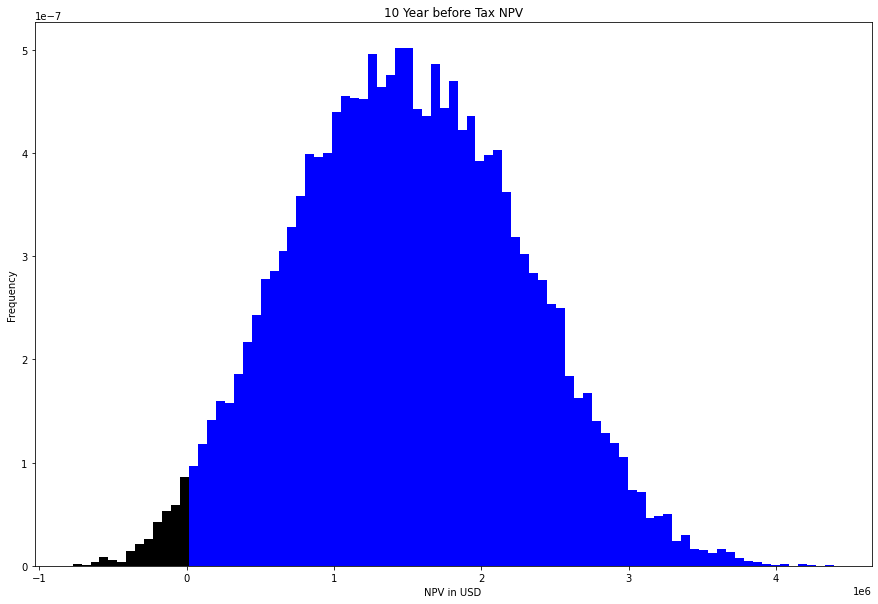

In [0]:
npv_10, irr_10 = get_results_plot(npv_irr_10, "10")

# After Tax NPV

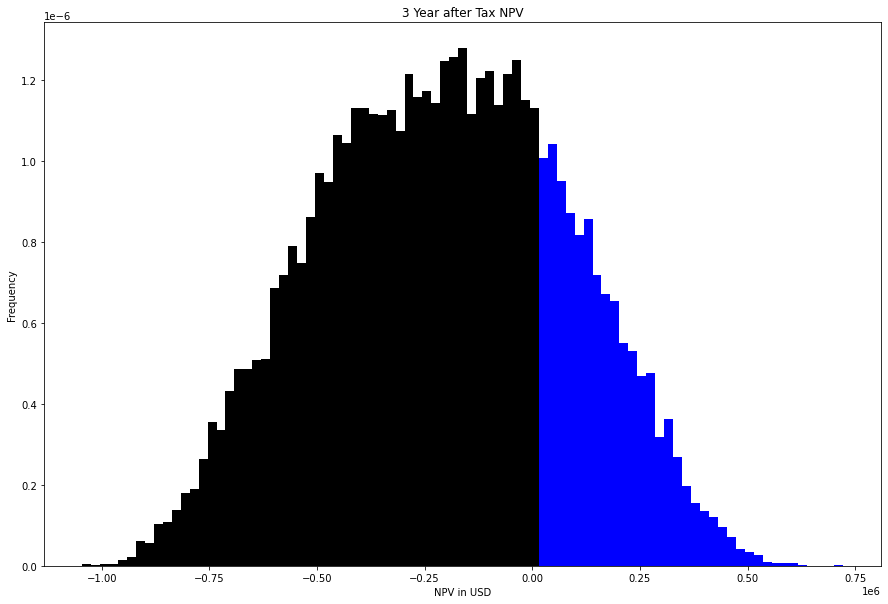

In [0]:
npv_3_after, irr_3_after = get_results_plot(npv_irr_after_tax_3, "3", before_tax=False)

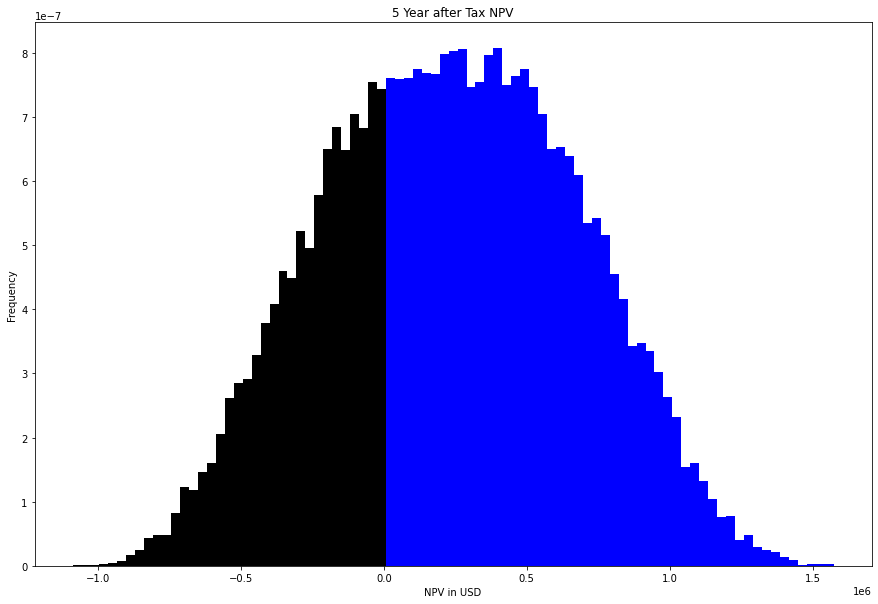

In [0]:
npv_5_after, irr_5_after = get_results_plot(npv_irr_after_tax_5, "5", before_tax=False)

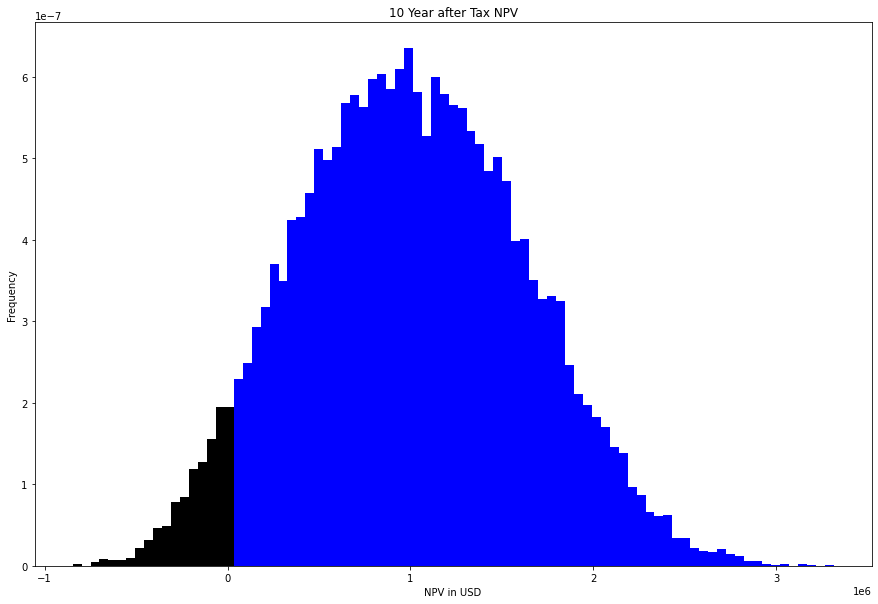

In [0]:
npv_10_after, irr_10_after = get_results_plot(npv_irr_after_tax_10, "10", before_tax=False)

In [0]:
print("10 year")
print(len([i for i in npv_10_after if i >= 0]) / 25000)
print(np.mean(npv_10_after))
print(np.median(npv_10_after))
print(min(npv_10_after))
print(max(npv_10_after))
print("\n5 Year")
print(len([i for i in npv_5_after if i >= 0]) / 25000)
print(np.mean(npv_5_after))
print(np.median(npv_5_after))
print(min(npv_5_after))
print(max(npv_5_after))
print("\n3 Year")
print(len([i for i in npv_3_after if i >= 0]) / 25000)
print(np.mean(npv_3_after))
print(np.median(npv_3_after))
print(min(npv_3_after))
print(max(npv_3_after))

10 year
0.951
1003596.2315308
988848.9450000001
-847005.58
3313072.64

5 Year
0.68208
234276.529082
235327.09
-1088505.3
1573383.72

3 Year
0.256
-207940.1629064
-203345.03
-1045082.5
722027.39

# Interpreting Results
We will only look at the after tax results in this scenario of `25k` simulations.

During our analysis, we have pulled out data for `3`, `5`, and `10` years. Given the following capital flows and distributions (determine with your company and cloud providers about what is reasonable), we have the following results for undertaking a project of migrating from on premise to cloud. For the `3` year period, we have that 
* `25.6%` of the results would yield a non-zero NPV, 
* a mean NPV of `-207,940` USD, 
* a median NPV of `-203,345` USD,
* a minimum NPV of `-1,045,082` USD, and
* a maximum NPV of `722,027` USD

If we had such a short time horizon, the risk of migrating to cloud wouldn't make sense in my opinion with only a `26%` chance of a profitable outcome. Next, let's consider the `5` year results.
* `68.2%` of the results would yield a non-zero NPV, 
* a mean NPV of `234,276` USD, 
* a median NPV of `235,327` USD,
* a minimum NPV of `-1,088,505` USD, and
* a maximum NPV of `1,573,383` USD

In the case of a `5` year time horizon, migrating to cloud would seem like a smart move in my opinion. There are some risk since in `32%` of the simulations, the factors combined to produce a negative outcome. Finally, let's look at the `10` year.
* `95.1%` of the results would yield a non-zero NPV, 
* a mean NPV of `1,003,596` USD, 
* a median NPV of `988,848` USD,
* a minimum NPV of `-847,005` USD, and
* a maximum NPV of `3,313,072` USD